In [1]:
import pandas as pd

In [2]:
df  = pd.read_csv(r"C:\Users\David gathara marigi\Downloads\loan_data_sample.csv", index_col = "SK_ID_CURR")

In [3]:
numeric_df = df.copy() 
numeric_df['NAME_CONTRACT_TYPE'] = numeric_df['NAME_CONTRACT_TYPE'].map({'Cash loans': 0, 'Revolving loans': 1}) 
numeric_df['CODE_GENDER'] = numeric_df['CODE_GENDER'].map({'M': 0, 'F': 1}) 
numeric_df['FLAG_OWN_CAR'] = numeric_df['FLAG_OWN_CAR'].map({'N': 0, 'Y': 1}) 
numeric_df['FLAG_OWN_REALTY'] = numeric_df['FLAG_OWN_REALTY'].map({'N': 0, 'Y': 1}) 
numeric_df['NAME_EDUCATION_TYPE'] = numeric_df['NAME_EDUCATION_TYPE'].map({'Lower secondary': 0, 'Secondary / secondary special': 0, 
                                       'Incomplete higher': 1, 
                                       'Higher education': 2, 
                                       'Academic degree': 2}) 
numeric_df.dropna(inplace=True)

In [4]:
numeric_df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 307217 entries, 100002 to 456255
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   TARGET               307217 non-null  int64  
 1   NAME_CONTRACT_TYPE   307217 non-null  int64  
 2   CODE_GENDER          307217 non-null  float64
 3   FLAG_OWN_CAR         307217 non-null  int64  
 4   FLAG_OWN_REALTY      307217 non-null  int64  
 5   CNT_CHILDREN         307217 non-null  int64  
 6   AMT_INCOME_TOTAL     307217 non-null  float64
 7   AMT_CREDIT           307217 non-null  float64
 8   AMT_ANNUITY          307217 non-null  float64
 9   AMT_GOODS_PRICE      307217 non-null  float64
 10  NAME_EDUCATION_TYPE  307217 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 28.1 MB


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
features = numeric_df.drop('TARGET', axis=1) 
targets = numeric_df['TARGET'] 
x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    targets, 
stratify=targets, 
random_state=42)

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [8]:
dt = DecisionTreeClassifier() 
dt.fit(x_train, y_train) 
print(f'Train accuracy: {dt.score(x_train, y_train)}')  
print(f'Test accuracy: {dt.score(x_test, y_test)}')

Train accuracy: 0.9835772442407513
Test accuracy: 0.8567150576134366


In [9]:
small_dt = DecisionTreeClassifier(max_depth=2, 
max_features=None) 
small_dt.fit(x_train, y_train) 
print(f'Train accuracy: {small_dt.score(x_train, y_train)}') 
print(f'Test accuracy: {small_dt.score(x_test, y_test)}')

Train accuracy: 0.9192620176032499
Test accuracy: 0.9192630688106244


In [10]:
import matplotlib.pyplot as plt 
from sklearn.tree import plot_tree

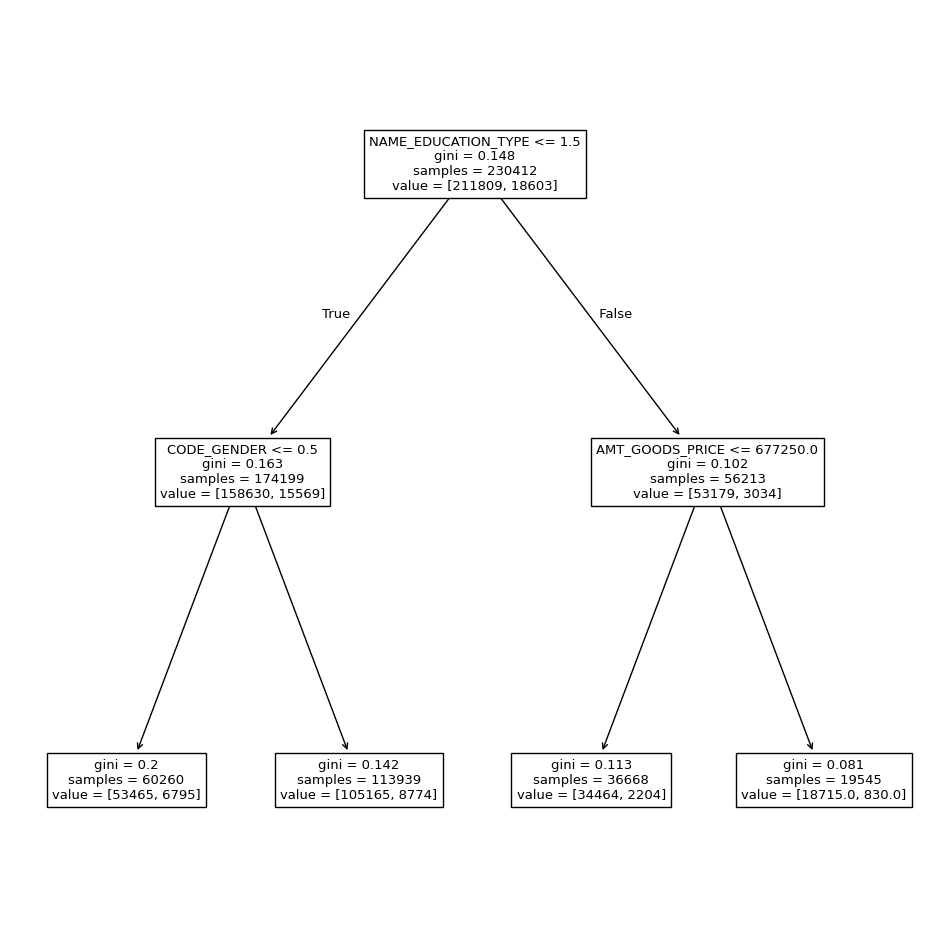

In [11]:
f = plt.figure(figsize=(12, 12)) 
_ = plot_tree(small_dt, feature_names=features.columns)

In [12]:
# random forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
rfc = RandomForestClassifier(max_depth=10, n_jobs=-1, 
random_state=42) 
rfc.fit(x_train, y_train) 
print(rfc.score(x_train, y_train)) 
print(rfc.score(x_test, y_test)) 

0.9192880579136503
0.9192630688106244


In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
x_tr_sample = x_train.sample(1000) 
y_tr_sample = y_train.loc[x_tr_sample.index] 
params = {'n_estimators': [100, 300, 500], 
'max_depth': [10, 15, 20], 
'max_features': [3, 6, 9], 
'random_state': [42], 
'n_jobs': [-1]} 
gs = GridSearchCV(rfc, param_grid=params, n_jobs=-1) 
gs.fit(x_tr_sample, y_tr_sample) 
print(gs.best_estimator_) 
print(gs.best_score_)

RandomForestClassifier(max_depth=10, max_features=6, n_jobs=-1, random_state=42)
0.914


In [17]:
import h2o 
h2o.init() 

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...


H2OStartupError: Cannot find Java. Please install the latest JRE from
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html#java-requirements

In [ ]:
hf = h2o.H2OFrame(df) 
hf['TARGET'] = hf['TARGET'].asfactor() 
train, valid = hf.split_frame(ratios=[.8], seed=42)

In [ ]:
from h2o.estimators import H2ORandomForestEstimator

In [ ]:
drf = H2ORandomForestEstimator(ntrees=100, max_depth=10, 
mtries=3) 
feature_columns = hf.columns
feature_columns.remove('TARGET') 
target_column = 'TARGET' 
drf.train(x=feature_columns, 
          y=target_column, 
          training_frame=train, 
          validation_frame=valid) 
drf.model_performance(valid).F1()

In [ ]:
predictions = drf.predict(train) 
(predictions['p1'] > 0.097).as_data_frame()['p1'].values

In [ ]:
save_path = h2o.save_model(model=drf, path='drf', force=True) 
drf2 = h2o.load_model(path=save_path)

In [ ]:
drf.varimp()
drf.varimp_plot(server=True)
plt.savefig() 

In [ ]:
from yellowbrick.model_selection import feature_importances 

In [ ]:
_ = feature_importances(gs.best_estimator_, 
                        x_train, 
                        y_train, 
                        colors=['darkblue'] * 
features.shape[0])

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier 
adaboost = AdaBoostClassifier(n_estimators=100, 
                              learning_rate=0.5, 
                              random_state=42) 
adaboost.fit(x_train, y_train) 
print(adaboost.score(x_train, y_train)) 
print(adaboost.score(x_test, y_test))

In [ ]:
from pycaret.classification import setup, create_model, tune_model

In [ ]:
classification = setup(data=numeric_df, target='TARGET')

In [ ]:
adaboost = create_model('ada', fold=3) 
tuned_adaboost, gridsearch = tune_model(adaboost, fold=3, 
return_tuner=True)

In [ ]:
""" XGBoost with PyCaret
 Again, we can use 
xgboost easily through 
pycaret , which, by default,
 searches the following hyperparameter space:
 learning_rate : 0.0000001 to 0.5
 n_estmators : 10-300 in steps of 10
 subsample : 0.2 to 1
 max_depth : 1 to 11 in steps of 1
 colsample_bytree : 0.5 to 1
 min_child_weight : 1 to 4 in steps of 1
 reg_alpha : 0.0000001 to 10
 reg_lambda : 0.0000001 to 10
 scale_pos_weight : 0 to 50 in steps of 0.1"""

In [ ]:
tune_distributions = {"learning_rate": UniformDistribution(0.000001, 0.5, log=True), 
"n_estimators": IntUniformDistribution(10, 300), 
"subsample": UniformDistribution(0.2, 1), 
"max_depth": IntUniformDistribution(1, 11), 
"colsample_bytree": UniformDistribution(0.5, 1), 
"min_child_weight": IntUniformDistribution(1, 4), 
"reg_alpha": UniformDistribution(0.0000000001, 10, 
log=True), 
    "reg_lambda": UniformDistribution(0.0000000001, 10, 
log=True), 
    "scale_pos_weight": UniformDistribution(1, 50), 
}

In [ ]:
xgb = create_model('xgboost', fold=3) 
best_xgb, tuner = tune_model(xgb, 
                             fold=3, 
                             search_library='scikit-optimize', 
                             return_tuner=True)

In [ ]:
best_xgb.get_params() 

In [ ]:
tuner.cv_results_['params']
tuner.cv_results_['mean_test_score']

In [ ]:
xgb_model.get_booster().get_score()

In [ ]:
best_xgb.feature_importances_ 

In [ ]:
import xgboost as xgb 

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train) 
dtest = xgb.DMatrix(x_test, label=y_test)

In [ ]:
xgb_model = xgb.train(params={'objective': 'binary:logistic'}, 
dtrain=dtrain)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
train_preds = xgb_model.predict(dtrain) 
test_preds = xgb_model.predict(dtest) 
print(accuracy_score(y_train, train_preds > 0.5)) 
print(accuracy_score(y_test, test_preds > 0.5))

In [ ]:
xgb_model = xgb.XGBClassifier()

In [ ]:
fit_model = xgb_model.fit(x_train, y_train)

In [ ]:
fit_model.score(x_train, y_train)

In [ ]:
# for gpu

In [ ]:
xgboost_gpu = create_model('xgboost', 
                           fold=3, 
                           tree_method='gpu_hist', 
                           gpu_id=0)

In [ ]:
light_gbm = create_model('lightgbm', fold=3) 
best_lgbm, tuner = tune_model(light_gbm, 
                              fold=3, 
                              search_library='scikit optimize', 
                              return_tuner=True)

In [ ]:
import lightgbm

In [ ]:
lightgbm.plot_importance(best_lgbm)

In [ ]:
lgb_model = lightgbm.LGBMClassifier()

In [ ]:
trained_lgb = lgb_model.fit(x_train, y_train)

In [ ]:
catboost_model = create_model('catboost', fold=3) 
best_cb, tuner = tune_model(catboost_model, 
                            fold=3, 
                            search_library='scikit-optimize', 
                            return_tuner=True)

In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
cb_model = CatBoostClassifier() 
catboost_train_data = Pool(x_train,  
                           y_train)

In [ ]:
cb_model.fit(catboost_train_data)

In [ ]:
cb_model.score(catboost_train_data)

In [ ]:
catboost_test_data = Pool(x_test) 
cb_model.predict(catboost_test_data)

In [ ]:
import catboost

In [ ]:
new_cb = catboost.CatBoostClassifier(**best_cb.get_params()) 
new_cb.set_params(n_estimators=1000) 
new_cb.fit(X=x_train, 
           y=y_train, 
           eval_set=(x_test, y_test), 
           early_stopping_rounds=10, 
           plot=True)